In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

#loading data
#ticker: AAPL (Apple), GOOGL (Google), TSLA (Tesla), BTC-USD (Bitcoin)
ticker =  "AAPL"
print (f"Downloading data for {ticker}...")

#getting data fro Jan 2020 to today
data = yf.download(ticker, start="2020-01-01", end="2026-01-01") 

[*********************100%***********************]  1 of 1 completed


In [4]:
#inspecting data
print(f"Total Trading Days: {data.shape[0]}")
print(data.head())

Total Trading Days: 1508
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.468262  72.528582  71.223259  71.476600  135480400
2020-01-03  71.763725  72.523754  71.539337  71.696167  146322800
2020-01-06  72.335556  72.374162  70.634539  70.885472  118387200
2020-01-07  71.995354  72.600960  71.775789  72.345204  108872000
2020-01-08  73.153488  73.455087  71.698574  71.698574  132079200


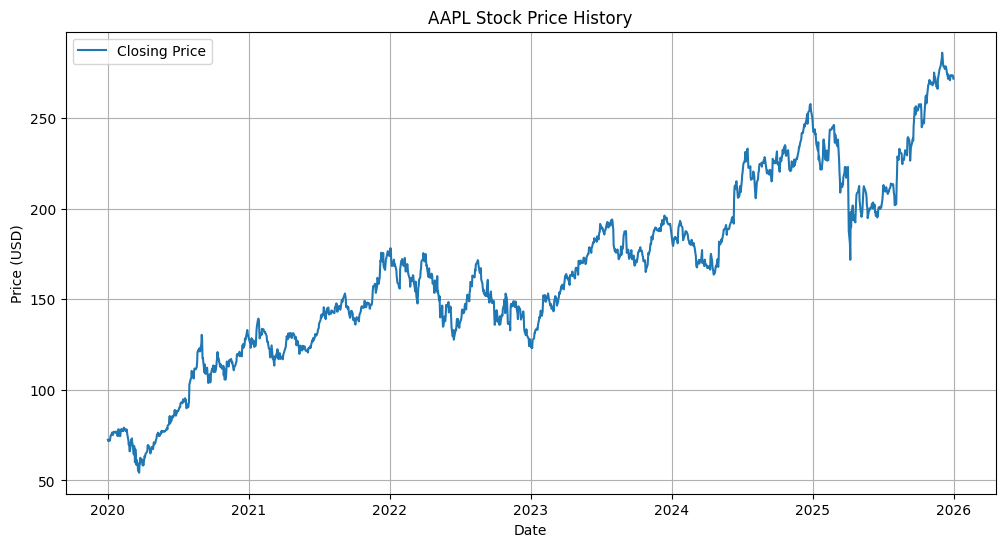

In [5]:
#visualizing closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closing Price')
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show() 

--- Checking Original Price ---
ADF Statistic: -0.9192
p-value: 0.7816
Data is NOT Stationary (Needs Differencing)

--- Checking Differenced Data ---
ADF Statistic: -38.0789
p-value: 0.0000
Data is STATIONARY (Ready for Modeling)


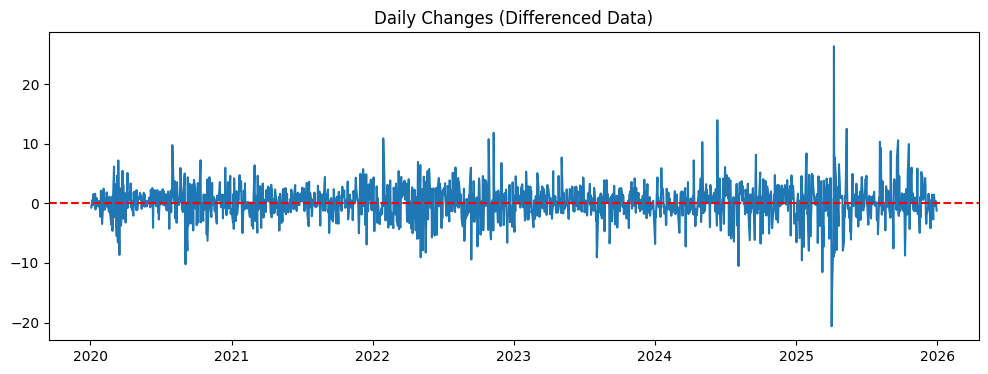

In [ ]:
from statsmodels.tsa.stattools import adfuller

#forcing the data to be a 1D Series
#this ensures it's a flat list, not a 1-column table
price_series = data['Close'].squeeze()

#defining the Test Function
def check_stationarity(series):
    #dropping NaN values immediately before passing to the test
    clean_series = series.dropna()
    
    #safety check: Is there data left?
    if len(clean_series) == 0:
        print("Error: Data is empty after dropping NaNs.")
        return

    try:
        result = adfuller(clean_series)
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        if result[1] < 0.05:
            print("Data is STATIONARY (Ready for Modeling)")
        else:
            print("Data is NOT Stationary (Needs Differencing)")
    except Exception as e:
        print(f"Error running ADF test: {e}")

#checking original price
print("--- Checking Original Price ---")
check_stationarity(price_series)

#creating and checking differenced data
#using the squeezed series to calculate the difference
diff_series = price_series.diff()

print("\n--- Checking Differenced Data ---")
check_stationarity(diff_series)

#plotting visuals
plt.figure(figsize=(12, 4))
plt.plot(diff_series)
plt.title('Daily Changes (Differenced Data)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

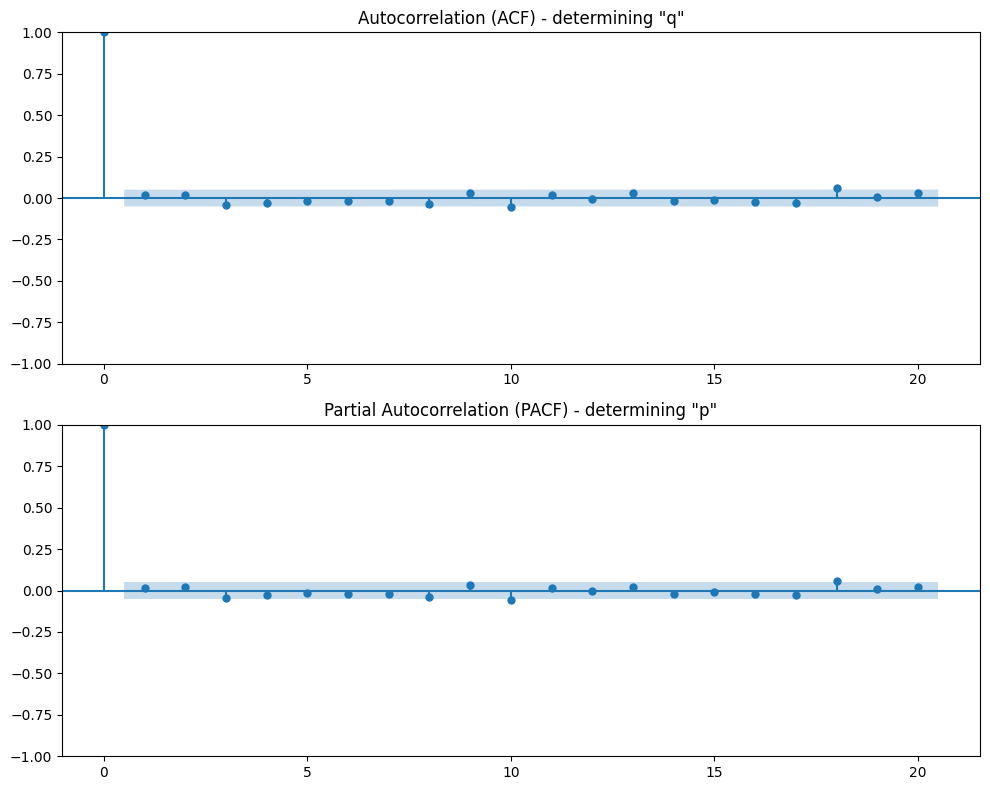

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#creating figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#plotting ACF (which determines 'q')
#using the differenced data
plot_acf(diff_series.dropna(), lags=20, ax=ax1)
ax1.set_title('Autocorrelation (ACF) - determining "q"')

#ploting PACF (which determines 'p')
plot_pacf(diff_series.dropna(), lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) - determining "p"')

plt.tight_layout()
plt.show() 

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

#splitting the data (keeping the last 60 days for testing)
train_data = price_series[:-60]
test_data = price_series[-60:]

print(f"Training on {len(train_data)} days")
print(f"Testing on {len(test_data)} days") 

Training on 1448 days
Testing on 60 days


In [10]:
#training the model
#order =(p,d,q) => (1,1,1)
model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit() 

print(fitted_model.summary()) 

c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1448
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3640.936
Date:                Mon, 12 Jan 2026   AIC                           7287.873
Time:                        14:13:25   BIC                           7303.704
Sample:                             0   HQIC                          7293.781
                               - 1448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9384      0.194     -4.845      0.000      -1.318      -0.559
ma.L1          0.9434      0.188      5.012      0.000       0.575       1.312
sigma2         8.9756      0.159     56.480      0.0

In [11]:
#forecasting test set
#start=Index of first test day, end=Index of last test day
forecast_result = fitted_model.get_forecast(steps=len(test_data))
forecast_series = forecast_result.predicted_mean
conf_int = forecast_result.conf_int() #confidence intervals


c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
#aligning the index for plotting
forecast_series.index = test_data.index
conf_int.index = test_data.index 

In [13]:
#calculating RMSE
rmse =  np.sqrt(mean_squared_error(test_data, forecast_series))
print(f"RMSE: ${rmse:.2f}") 

RMSE: $15.90


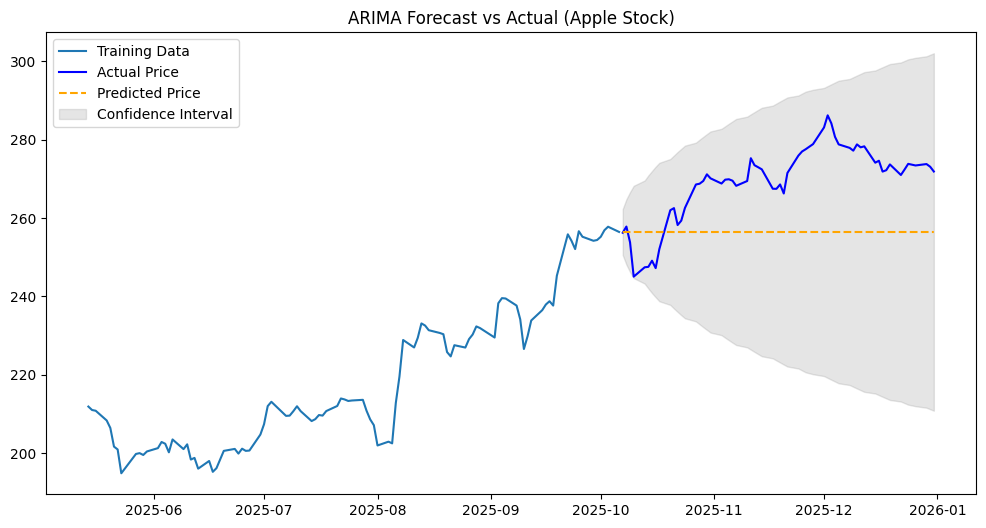

In [14]:
#visualizing RMSE
plt.figure(figsize=(12, 6))
#plotting training data (using only rthe end for clear details)
plt.plot(train_data.index[-100:], train_data[-100:], label='Training Data')
#plotting actual test data
plt.plot(test_data.index, test_data, label='Actual Price', color='blue')
#plotting forecast
plt.plot(forecast_series.index, forecast_series, label='Predicted Price', color='orange', linestyle='--')
#plotting confidence interval
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='grey', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast vs Actual (Apple Stock)')
plt.legend()
plt.show() 